# Aggregating and weighting diverse data

In this notebook, we illustrate the aggregation of various data, and how to combine that with an adaptive scheme of computing weights.

## Aggregating diverse distance functions

Now, we want to combine different distance metrics operating on subsets of the data to one distance value. We consider a slightly advanced model, combining a conversion reaction ODE model with samples from a normal distribution.

In [1]:
import pyabc
import numpy as np
import scipy as sp
from scipy import stats
import os
import tempfile
import matplotlib.pyplot as plt

# true parameters
theta1_true, theta2_true = sp.exp([-2.5, -2])
theta_true = dict(theta1=theta1_true, theta2=theta2_true)

/home/yannik/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
# conversion reaction (cr) model

measurement_data = sp.array([0.0244, 0.0842, 0.1208,
                             0.1724, 0.2315, 0.2634,
                             0.2831, 0.3084, 0.3079,
                             0.3097, 0.3324])
measurement_times = sp.arange(len(measurement_data))      
init = sp.array([1, 0])


def f(y, t0, theta1, theta2):
    x1, x2 = y
    dx1 = - theta1 * x1 + theta2 * x2
    dx2 =   theta1 * x1 - theta2 * x2
    return dx1, dx2


def cr_model(p):
    sol = sp.integrate.odeint(
             f, init, measurement_times,
             args=(p["theta1"], p["theta2"]))
    return {"X_2": sol[:,1]}


def cr_l1_distance(simulation, data):
    return sp.absolute(data["X_2"] - simulation["X_2"]).sum()

In [3]:
# normal distribution samples


def gauss_model(p):
    samples = p['theta1'] + np.random.normal(size=100)
    return {'samples': samples}


def gauss_ks_distance(simulation, data):
    return stats.ks_2samp(simulation['samples'], data['samples']).statistic

observed_samples = gauss_model(theta_true)['samples']
# observation
observation = {'X_2': measurement_data,
               'samples': observed_samples}

The key is now to use `pyabc.distance.AggregatedDistance` to combine both.

In [4]:
def model(p):
    cr_ss = cr_model(p)
    gauss_ss = gauss_model(p)
    return {'X_2': cr_ss['X_2'], 'samples': gauss_model(p)['samples']}


distance = pyabc.distance.AggregatedDistance(
    distances=[cr_l1_distance, gauss_ks_distance], weights=[1, 10])
                           
# prior                           
parameter_prior = pyabc.Distribution(theta1=pyabc.RV("uniform", 0, 1),
                                     theta2=pyabc.RV("uniform", 0, 1))


abc = pyabc.ABCSMC(models=model,
                   parameter_priors=parameter_prior,
                   distance_function=distance,)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
h = abc.run(minimum_epsilon=0.1, max_nr_populations=5)

INFO:History:Start <ABCSMC(id=43, start_time=2019-09-28 19:43:08.133070, end_time=None)>
INFO:Epsilon:initial epsilon is 4.256691841746394
INFO:ABC:t:0 eps:4.256691841746394
INFO:ABC:t:1 eps:2.4983659009074133
INFO:ABC:t:2 eps:1.9399577189626975
INFO:ABC:t:3 eps:1.5991326823282404
INFO:ABC:t:4 eps:1.379995516014459
INFO:History:Done <ABCSMC(id=43, start_time=2019-09-28 19:43:08.133070, end_time=2019-09-28 19:43:15.534640)>


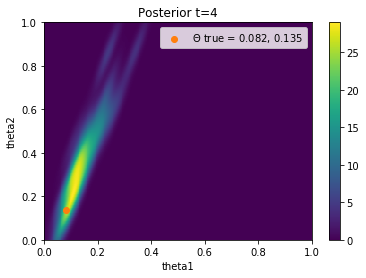

In [5]:
for t in range(h.max_t, h.max_t+1):
    ax = pyabc.visualization.plot_kde_2d(*h.get_distribution(m=0, t=t),
                                         "theta1", "theta2",
                xmin=0, xmax=1, numx=300,
                ymin=0, ymax=1, numy=300)
    ax.scatter([theta1_true], [theta2_true],
                color="C1",
                label='$\Theta$ true = {:.3f}, {:.3f}'.format(
                    theta1_true, theta2_true))
    ax.set_title("Posterior t={}".format(t))
    ax.legend()

In [6]:
for _ in range(10):
    p = dict(parameter_prior.rvs())
    sim = model(p)
    print(p, cr_l1_distance(sim, observation), gauss_ks_distance(sim, observation))
print(theta_true, gauss_ks_distance(observation, observation))

{'theta1': 0.12009571571292843, 'theta2': 0.8701446080606711} 1.2970858966618226 0.12
{'theta1': 0.15129718158081595, 'theta2': 0.04056348984300129} 2.3152931817360973 0.14
{'theta1': 0.8426704831440074, 'theta2': 0.12000837650118679} 5.823261006778938 0.36000000000000004
{'theta1': 0.5509920827658124, 'theta2': 0.015231700614990795} 6.068334350939666 0.21000000000000008
{'theta1': 0.9283229143153618, 'theta2': 0.845325666306257} 2.737589596229 0.39
{'theta1': 0.5633722930066327, 'theta2': 0.0746451524704429} 5.453209888376703 0.23000000000000004
{'theta1': 0.4990293996312348, 'theta2': 0.8772395315556815} 1.1140641154446358 0.21
{'theta1': 0.08235421157559553, 'theta2': 0.848933542169427} 1.6113955914576314 0.10999999999999999
{'theta1': 0.06346736320071333, 'theta2': 0.8439520314721705} 1.78609266746895 0.08000000000000002
{'theta1': 0.22390287891507799, 'theta2': 0.19893652929017247} 1.9143447620642302 0.15000000000000002
{'theta1': 0.0820849986238988, 'theta2': 0.1353352832366127} 

## Weighted aggregation

A problem with the previous aggregation of distance function is that usually they vary on different scales. In order to account for all in a similar manner, one thing one can do is to weight them.

Let us look at a simple example of two summary statistics which vary on very different scales:

INFO:History:Start <ABCSMC(id=44, start_time=2019-09-28 19:43:24.195388, end_time=None)>
INFO:Epsilon:initial epsilon is 73.98136826133761
INFO:ABC:t:0 eps:73.98136826133761
INFO:ABC:t:1 eps:32.73742300462455
INFO:ABC:t:2 eps:17.451598087954135
INFO:ABC:t:3 eps:8.98689199755342
INFO:ABC:t:4 eps:5.367386074360483
INFO:ABC:t:5 eps:2.995482553509668
INFO:ABC:t:6 eps:1.793235992829435
INFO:ABC:t:7 eps:1.162536710013759
INFO:History:Done <ABCSMC(id=44, start_time=2019-09-28 19:43:24.195388, end_time=2019-09-28 19:44:58.966265)>


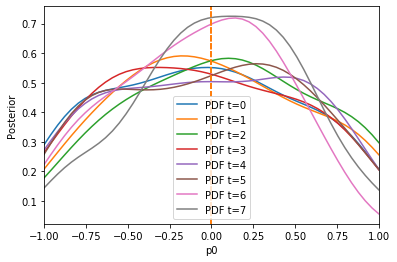

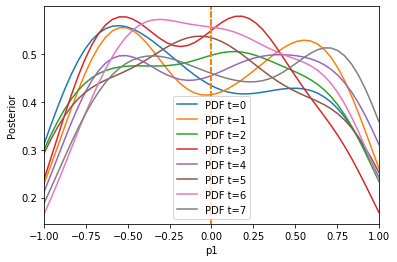

In [7]:
import pyabc
import numpy as np
import scipy as sp
from scipy import stats
import os
import tempfile
import matplotlib.pyplot as plt

p_true = {'p0': 0, 'p1': 0}

def model(p):
    return {'s0': p['p0'] + 0.1 * sp.randn(), 's1': p['p1'] + 100 * sp.randn()}

observation = {'s0': 0, 's1': 0}

def distance0(x, x_0):
    return abs(x['s0'] - x_0['s0'])

def distance1(x, x_0):
    return abs(x['s1'] - x_0['s1'])

# prior                           
prior = pyabc.Distribution(
    p0=pyabc.RV("uniform", -1, 2),
    p1=pyabc.RV("uniform", -1, 2))

distance = pyabc.distance.AggregatedDistance([distance0, distance1])

abc = pyabc.ABCSMC(model, prior, distance)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history1 = abc.run(max_nr_populations=8)

# plotting

def plot(history):
    fig, ax = plt.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=-1, xmax=1,
                                        x='p0', ax=ax,
                                        label="PDF t={}".format(t),
                                        refval=p_true)
    ax.legend()

    fig, ax = plt.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=-1, xmax=1,
                                        x='p1', ax=ax,
                                        label="PDF t={}".format(t),
                                        refval=p_true)
    ax.legend()
    
plot(history1)

The algorithm has problems extracting information from the first summary statistic on the first parameter, because the second summary statistic is on a much larger scale. Let us use the `AdaptiveAggregatedDistance` instead, which tries to find good weights itself (and even adapts these weights over time):

INFO:History:Start <ABCSMC(id=47, start_time=2019-09-28 19:45:00.792579, end_time=None)>
INFO:Epsilon:initial epsilon is 0.8084154158890122
INFO:ABC:t:0 eps:0.8084154158890122
INFO:ABC:t:1 eps:0.678481178248394
INFO:ABC:t:2 eps:0.8276154181760381
INFO:ABC:t:3 eps:0.7667684668316394
INFO:ABC:t:4 eps:0.7905640645559909
INFO:ABC:t:5 eps:0.9033328124830712
INFO:ABC:t:6 eps:0.7226151700245221
INFO:ABC:t:7 eps:0.8230838655765563
INFO:History:Done <ABCSMC(id=47, start_time=2019-09-28 19:45:00.792579, end_time=2019-09-28 19:45:31.407919)>


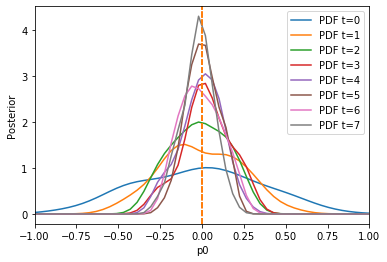

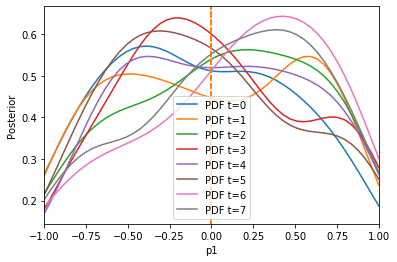

In [8]:
# prior                           
prior = pyabc.Distribution(
    p0=pyabc.RV("uniform", -1, 2),
    p1=pyabc.RV("uniform", -1, 2))

distance = pyabc.distance.distance.AdaptiveAggregatedDistance(
    [distance0, distance1])

abc = pyabc.ABCSMC(model, prior, distance)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history2 = abc.run(max_nr_populations=8)

plot(history2)

The result is much better. We can also only initially calculate weights by setting `adaptive=False`:

INFO:History:Start <ABCSMC(id=48, start_time=2019-09-28 19:45:32.849783, end_time=None)>
INFO:Epsilon:initial epsilon is 0.8436585235793332
INFO:ABC:t:0 eps:0.8436585235793332
INFO:ABC:t:1 eps:0.5461797740767041
INFO:ABC:t:2 eps:0.3424954164033174
INFO:ABC:t:3 eps:0.24089773055472563
INFO:ABC:t:4 eps:0.1625326820200019
INFO:ABC:t:5 eps:0.10829217267539021
INFO:ABC:t:6 eps:0.07912041468020233
INFO:ABC:t:7 eps:0.055020202299396144
INFO:History:Done <ABCSMC(id=48, start_time=2019-09-28 19:45:32.849783, end_time=2019-09-28 19:46:08.897769)>


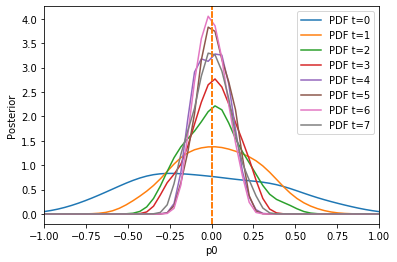

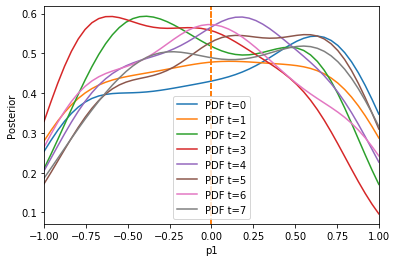

In [9]:
# prior                           
prior = pyabc.Distribution(
    p0=pyabc.RV("uniform", -1, 2),
    p1=pyabc.RV("uniform", -1, 2))

distance = pyabc.distance.distance.AdaptiveAggregatedDistance([distance0, distance1], adaptive=False)

abc = pyabc.ABCSMC(model, prior, distance)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history3 = abc.run(max_nr_populations=8)

plot(history3)

Here, pre-calibration performs comparable to adaptation, because the weights do not change so much over time.

We can also use other scale functions:

INFO:History:Start <ABCSMC(id=49, start_time=2019-09-28 19:46:10.847263, end_time=None)>
INFO:Epsilon:initial epsilon is 1.8614437816997165
INFO:ABC:t:0 eps:1.8614437816997165
INFO:ABC:t:1 eps:2.057460941237172
INFO:ABC:t:2 eps:2.216793828188394
INFO:ABC:t:3 eps:2.104425941325356
INFO:ABC:t:4 eps:2.1391611814777467
INFO:ABC:t:5 eps:2.1681751971796577
INFO:ABC:t:6 eps:2.0387021022939202
INFO:ABC:t:7 eps:2.260484114384987
INFO:History:Done <ABCSMC(id=49, start_time=2019-09-28 19:46:10.847263, end_time=2019-09-28 19:46:55.684061)>


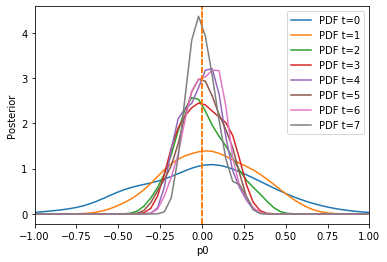

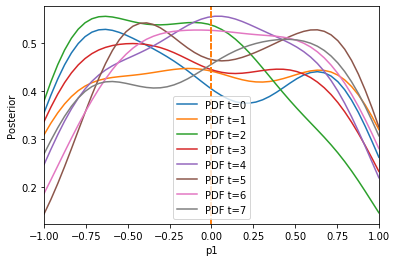

In [10]:
# prior                           
prior = pyabc.Distribution(
    p0=pyabc.RV("uniform", -1, 2),
    p1=pyabc.RV("uniform", -1, 2))

distance = pyabc.distance.distance.AdaptiveAggregatedDistance(
    [distance0, distance1], scale_function=pyabc.distance.scales.mean)

abc = pyabc.ABCSMC(model, prior, distance)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history4 = abc.run(max_nr_populations=8)

plot(history4)

The following plots demonstrate that we not only have a much better posterior approximation after the same number of iterations in the second and third run compared to the first, but we achieve that actually with a much lower number of samples.

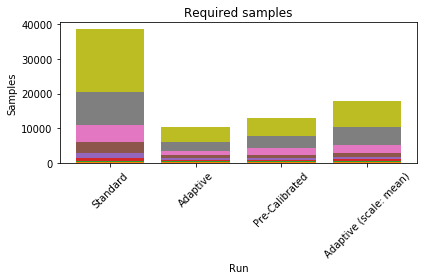

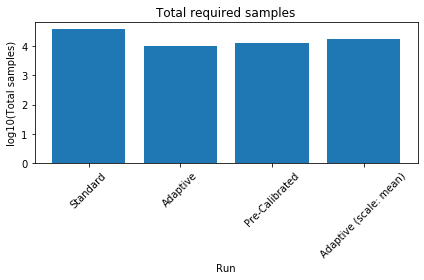

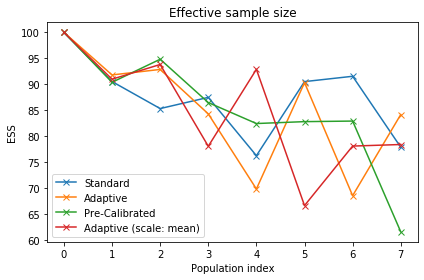

In [11]:
histories = [history1, history2, history3, history4]
labels = ["Standard", "Adaptive", "Pre-Calibrated", "Adaptive (scale: mean)"]

pyabc.visualization.plot_sample_numbers(histories, labels, rotation=45)
pyabc.visualization.plot_total_sample_numbers(histories, labels, yscale='log10', rotation=45)
pyabc.visualization.plot_effective_sample_sizes(histories, labels)